In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install pystan~=2.14
!pip install fbprophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62.6 MB 1.8 MB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.2 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6750371 sha256=4db65d981f6eed8e25a367050c8da1840e603c27e9af2ef4e8a4589a4d2843dd
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import to_datetime
from fbprophet import Prophet

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


In [5]:
df = pd.read_csv(path + 'cs448b_ipasn.csv')
df.head(10)

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1
5,2006-07-01,0,3320,1
6,2006-07-01,0,3561,13
7,2006-07-01,0,4134,3
8,2006-07-01,0,5617,2
9,2006-07-01,0,6478,1


In [6]:
print('dataframe shape {} '.format(df.shape))

dataframe shape (20803, 4) 


In [7]:
print('Number of days for which data is available {:d}'.format(df['date'].nunique()))
print('Unique local ip {:d}'.format(df['l_ipn'].nunique()))
print('Unique remote ASN {:d}'.format(df['r_asn'].nunique()))
print('Minimum flow count per day {:d}'.format(df['f'].min()))
print('Maximum flow count per day {:d}'.format(df['f'].max()))

Number of days for which data is available 92
Unique local ip 10
Unique remote ASN 2005
Minimum flow count per day 1
Maximum flow count per day 784234


In [8]:
#Missing or NAN values in dataset
df.isnull().sum()

date     0
l_ipn    0
r_asn    0
f        0
dtype: int64

In [9]:
dic = {'2006-08-24':1,'2006-09-04':5,'2006-09-18':4,'2006-09-26':3,'2006-09-26':6}
marked_anomalies = pd.DataFrame.from_dict(dic,orient='index')
marked_anomalies.reset_index(inplace = True)
marked_anomalies.columns = ['date','l_ipn']
print(marked_anomalies)

         date  l_ipn
0  2006-08-24      1
1  2006-09-04      5
2  2006-09-18      4
3  2006-09-26      6


In [10]:
#Aggregating daily connections
daily_aggregate = df.groupby(['date'])[['f']].sum()
daily_aggregate.reset_index(inplace = True)

In [11]:
daily_aggregate[['f']].describe()

,f
count,92.000000
mean,21235.847826
std,85752.692609
min,2706.000000
25%,5211.750000
50%,8773.500000
75%,12426.000000
max,788297.000000


In [12]:
daily_mean = round(daily_aggregate['f'].mean(),2)

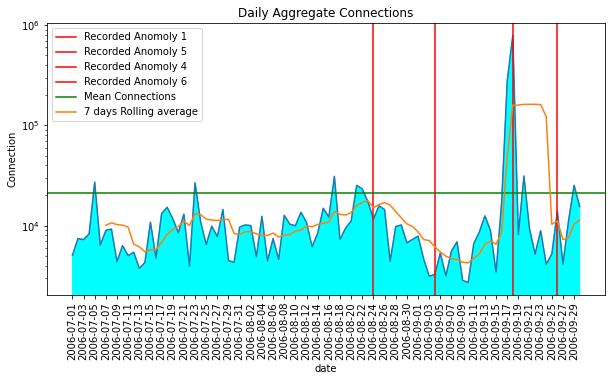

In [13]:
plt.figure(figsize=(10,5))
plt.plot(daily_aggregate['date'],daily_aggregate['f'])
[plt.axvline(x=_x, color='r' , label = 'Recorded Anomoly {}'.format(ip)) for _x,ip in list(marked_anomalies[['date','l_ipn']].to_records(index=False))]
plt.axhline(y= daily_mean, color='g', label = 'Mean Connections')
plt.plot(daily_aggregate['date'],daily_aggregate['f'].rolling(7).mean(), label = '7 days Rolling average')
plt.xticks(daily_aggregate['date'][::2],  rotation='vertical')
plt.yscale('log')
plt.xlabel('date')
plt.ylabel('Connection')
plt.title('Daily Aggregate Connections')
plt.fill_between(daily_aggregate['date'],daily_aggregate['f'],color='aqua')
plt.legend()
plt.show()

In [14]:
daily_aggregate_l_ipn = df.groupby(['l_ipn','date'])[['f']].sum()
daily_aggregate_l_ipn.reset_index(inplace= True)

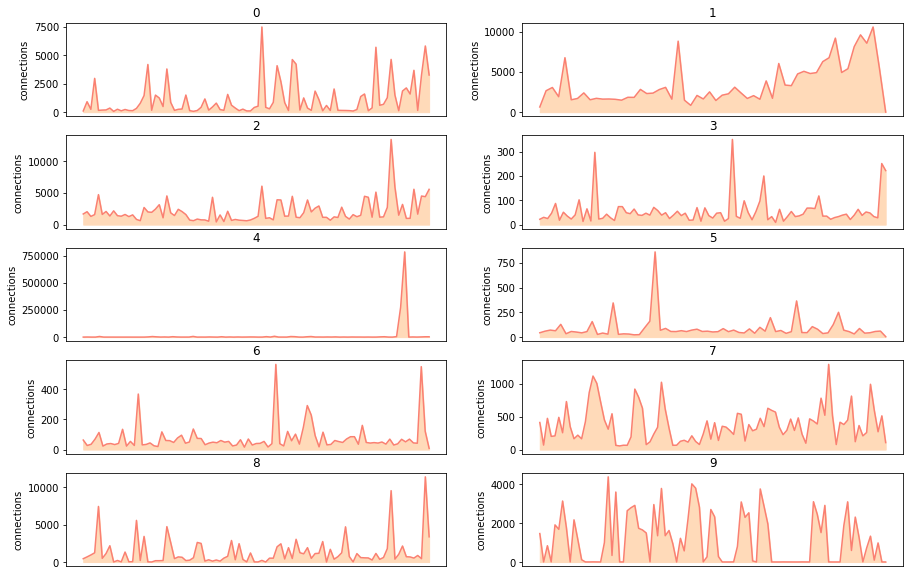

In [15]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))

plot_row = 0
plot_col = 0

for i in range(df['l_ipn'].nunique()):
    temp = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == i]
    axes[plot_row,plot_col].set_title(i)
    axes[plot_row,plot_col].set_xlabel('date')
    axes[plot_row,plot_col].set_ylabel('connections')
    
    axes[plot_row,plot_col].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    axes[plot_row,plot_col].plot(temp['date'],temp['f'], color = 'salmon')
    axes[plot_row,plot_col].get_xaxis().set_visible(False)
    axes[plot_row,plot_col].fill_between(temp['date'],temp['f'], color='peachpuff')
    

    plot_col = plot_col + 1
    if(plot_col == 2):
        plot_row = plot_row + 1
        plot_col = 0
plt.show()

In [16]:
daily_aggregate_r_asn = df.groupby(['r_asn'])[['f']].sum()
daily_aggregate_r_asn.reset_index(inplace = True)

In [17]:
pd.options.display.float_format = '{:.2f}'.format
daily_aggregate_r_asn['f'].describe()

count      2005.00
mean        974.41
std       23862.63
min           1.00
25%           2.00
50%           8.00
75%          43.00
max     1059254.00
Name: f, dtype: float64

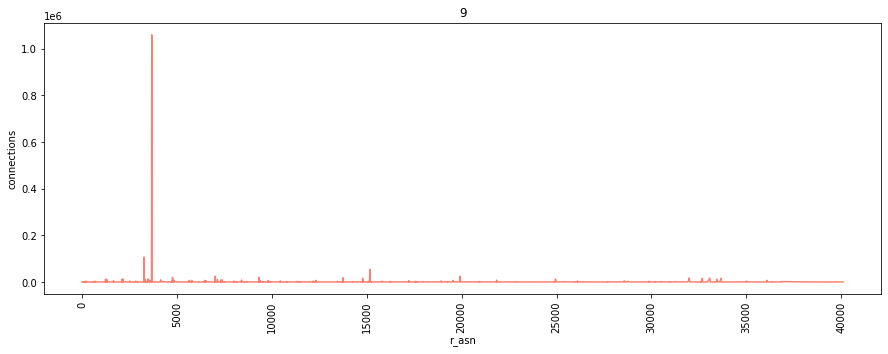

In [18]:
plt.figure(figsize=(15,5))
plt.title(i)
plt.xlabel('r_asn')
plt.ylabel('connections')
plt.xticks(rotation='vertical')
#n_bins =  daily_aggregate_r_asn['r_asn']
#plt.hist(daily_aggregate_r_asn['f'], n_bins, histtype ='bar')
plt.plot(daily_aggregate_r_asn['r_asn'],daily_aggregate_r_asn['f'], color = 'salmon')
plt.show()

In [19]:
def get_daily_aggregate_l_ipn(in_l_ipn):
    temp_df = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == in_l_ipn].drop(['l_ipn'],axis = 1)
    temp_df.columns = ['ds','y']
    temp_df['ds'] = to_datetime(temp_df['ds'])
    temp_df.reset_index(inplace=True,drop=True)
    return temp_df

In [20]:
def get_forecast(ts,in_l_ipn):
    
    model = Prophet(seasonality_mode='additive',daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = True)
    model.fit(ts)
    forecast = model.predict(pd.DataFrame(ts['ds']))
    
    ts['anomaly'] = 0
    p_color = np.full((ts.shape[0],1),'green')
    for i in range(forecast.shape[0]):
        if((forecast.at[i,'yhat_lower'] > ts.at[i,'y']) or (forecast.at[i,'yhat_upper'] < ts.at[i,'y'])):
            ts.at[i,'anomaly'] = 1
            p_color[i] = 'red'
                
    model.plot(forecast)
    
    plt.scatter(ts['ds'],ts['y'],c=p_color.ravel())
    plt.title('Forcast plot for l_ipn %d' %in_l_ipn)
    plt.show()

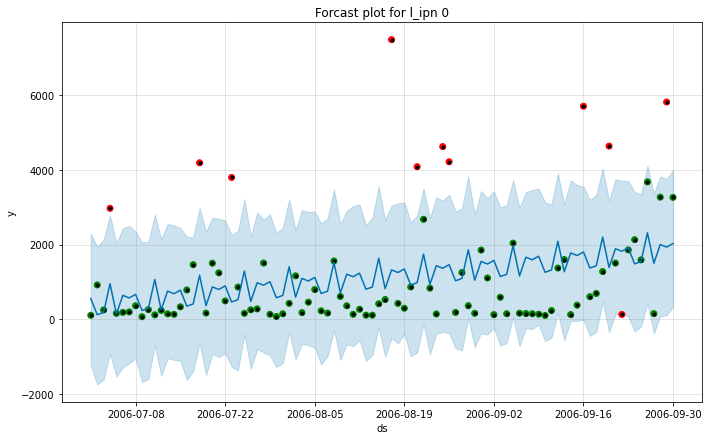

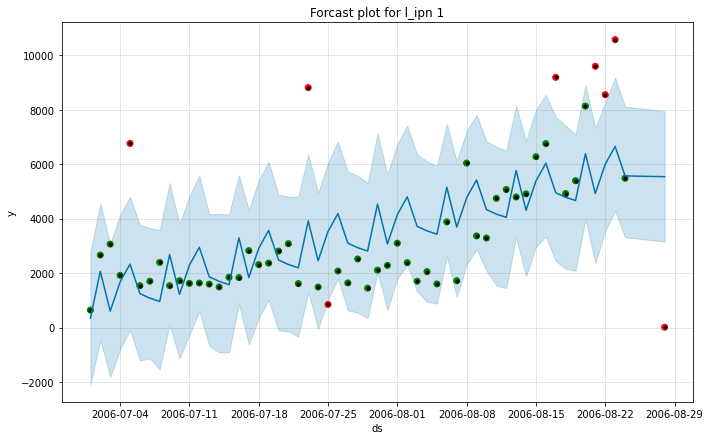

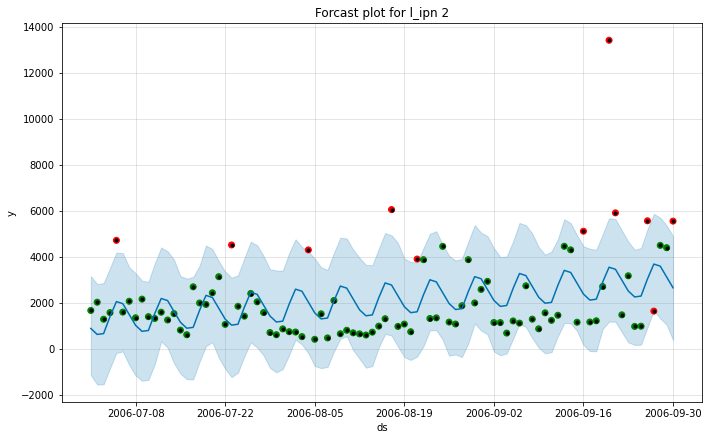

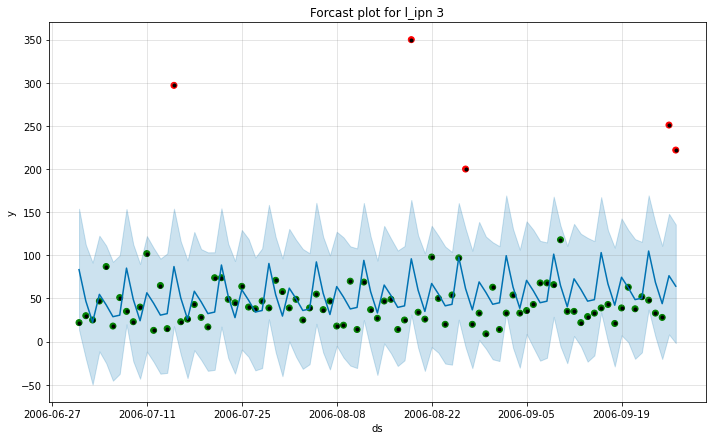

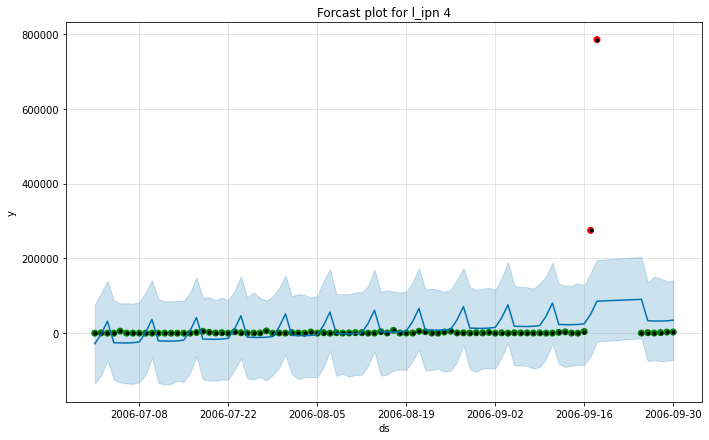

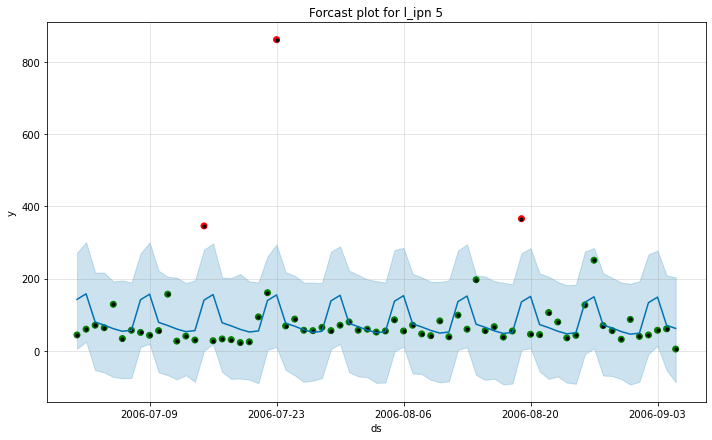

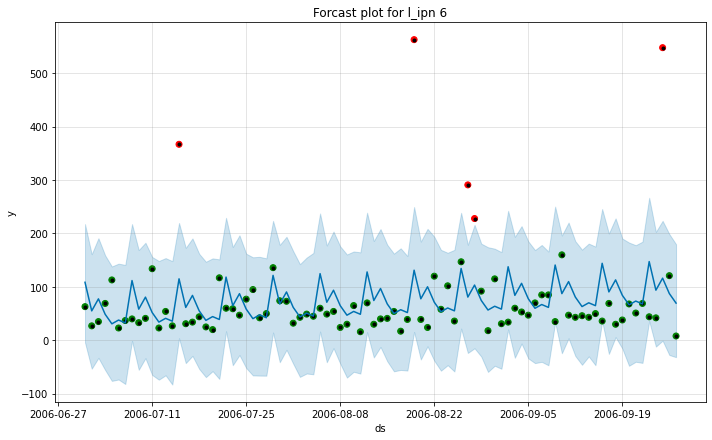

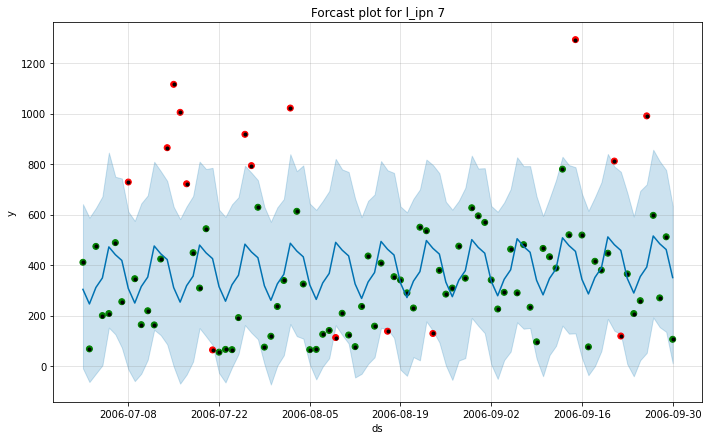

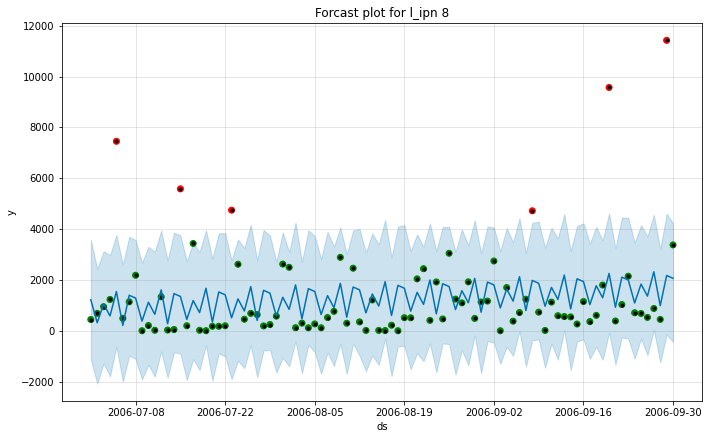

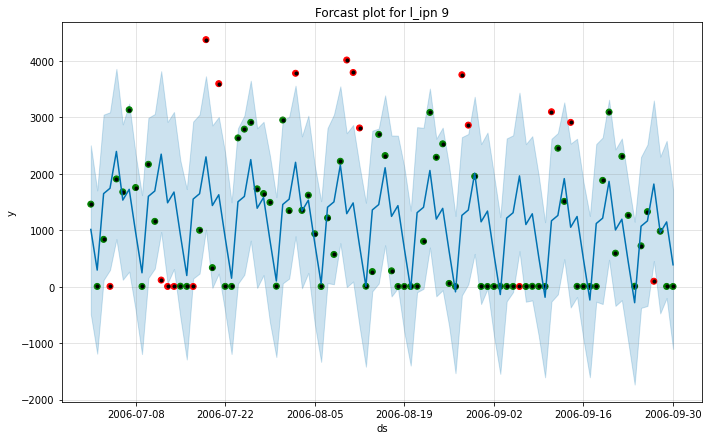

In [21]:
for i in range(df['l_ipn'].nunique()):
    get_forecast(get_daily_aggregate_l_ipn(i),i)

In [ ]:
pip install luminol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import luminol
from luminol.anomaly_detector import AnomalyDetector

In [ ]:
def get_luminol_anomalies(in_df):
    in_df['isAnomaly'] = 0
    detector = AnomalyDetector(in_df['y'].to_dict())
    anomalies = detector.get_anomalies()
    time_period = ()
    for j in range(len(anomalies)):
        time_period = anomalies[j].get_time_window()
        for k in time_period:
            in_df.at[k,'isAnomaly'] = 1     
    return(in_df)    

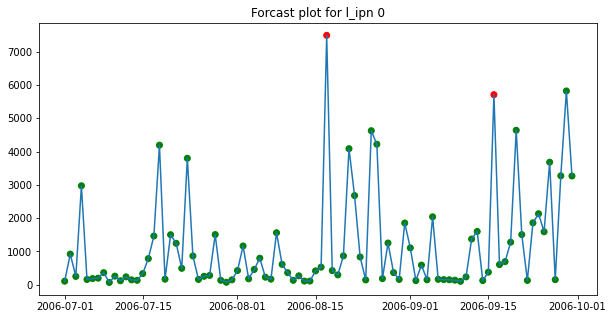

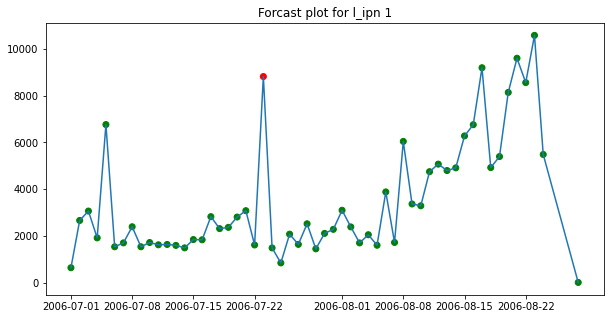

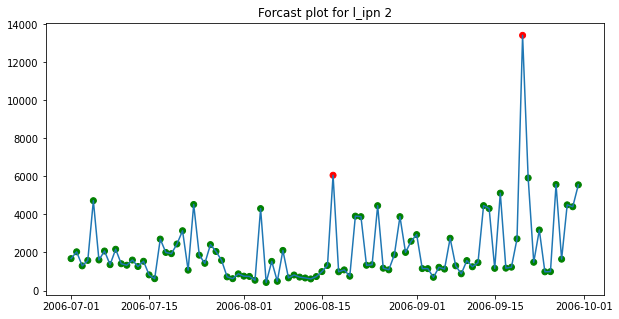

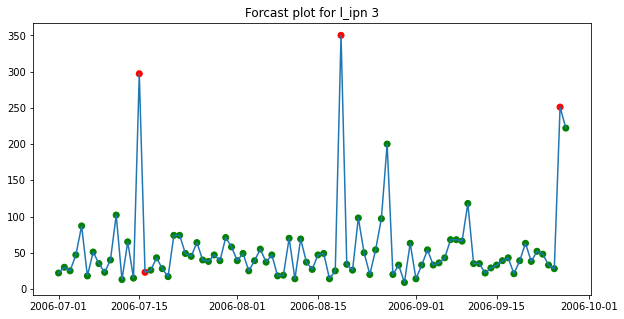

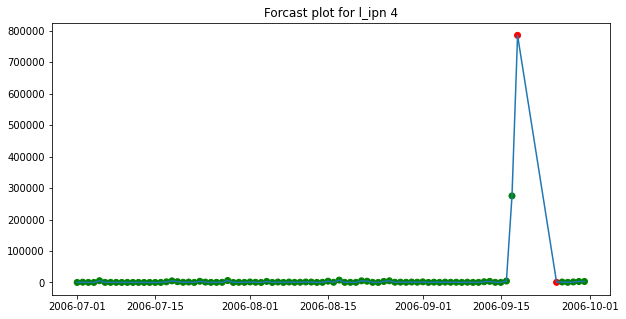

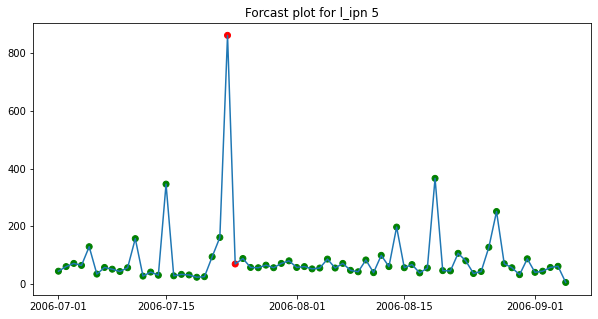

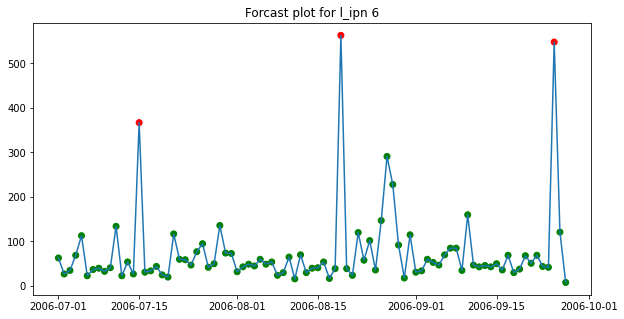

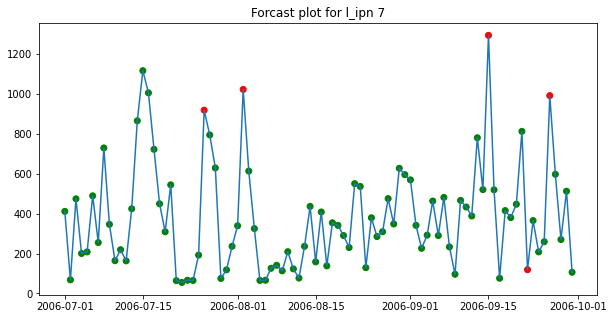

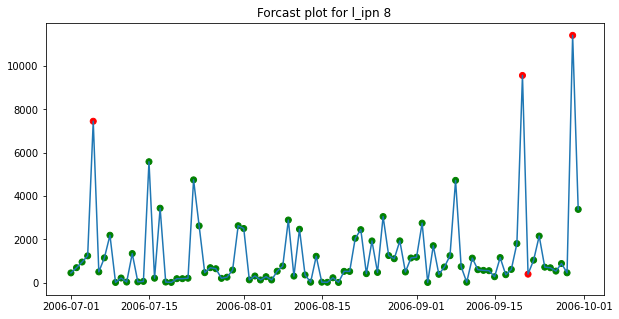

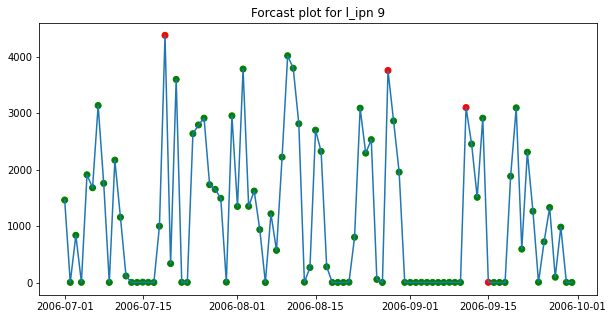

In [ ]:
for i in range(df['l_ipn'].nunique()):
    t_df = get_luminol_anomalies(get_daily_aggregate_l_ipn(i))
    
    colors = {0:'green', 1:'red'}
   
    plt.figure(figsize=(10,5))
    plt.plot(t_df['ds'],t_df['y'])
    plt.scatter(t_df['ds'],t_df['y'],c=t_df['isAnomaly'].apply(lambda x: colors[x]))
    plt.title('Forcast plot for l_ipn %d' %i)
    plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df['date']= pd.to_datetime(df['date'])
df = df.groupby(['date','l_ipn'],as_index=False).sum()

In [ ]:
df['yday'] = df['date'].dt.dayofyear
df['wday'] = df['date'].dt.dayofweek

In [ ]:
ip0 = df[df['l_ipn']==0]
max0 = np.max(ip0['f'])
ip1 = df[df['l_ipn']==1]
max1 = np.max(ip1['f'])
ip2 = df[df['l_ipn']==2]
max2 = np.max(ip2['f'])
ip3 = df[df['l_ipn']==3]
max3 = np.max(ip3['f'])
ip4 = df[df['l_ipn']==4]
max4 = np.max(ip4['f'])
ip5 = df[df['l_ipn']==5]
max5 = np.max(ip5['f'])
ip6 = df[df['l_ipn']==6]
max6 = np.max(ip6['f'])
ip7 = df[df['l_ipn']==7]
max7 = np.max(ip7['f'])
ip8 = df[df['l_ipn']==8]
max8 = np.max(ip8['f'])
ip9 = df[df['l_ipn']==9]
max9 = np.max(ip9['f'])
ip0.head(2)

,date,l_ipn,r_asn,f,yday,wday
0,2006-07-01,0,436704,106,182,5
10,2006-07-02,0,460025,920,183,6


In [ ]:
count, division = np.histogram(ip0['f'],bins=10)
division

array([  68.,  810., 1552., 2294., 3036., 3778., 4520., 5262., 6004.,
       6746., 7488.])

Text(0.5, 1.0, 'Local IP 9 Flow')

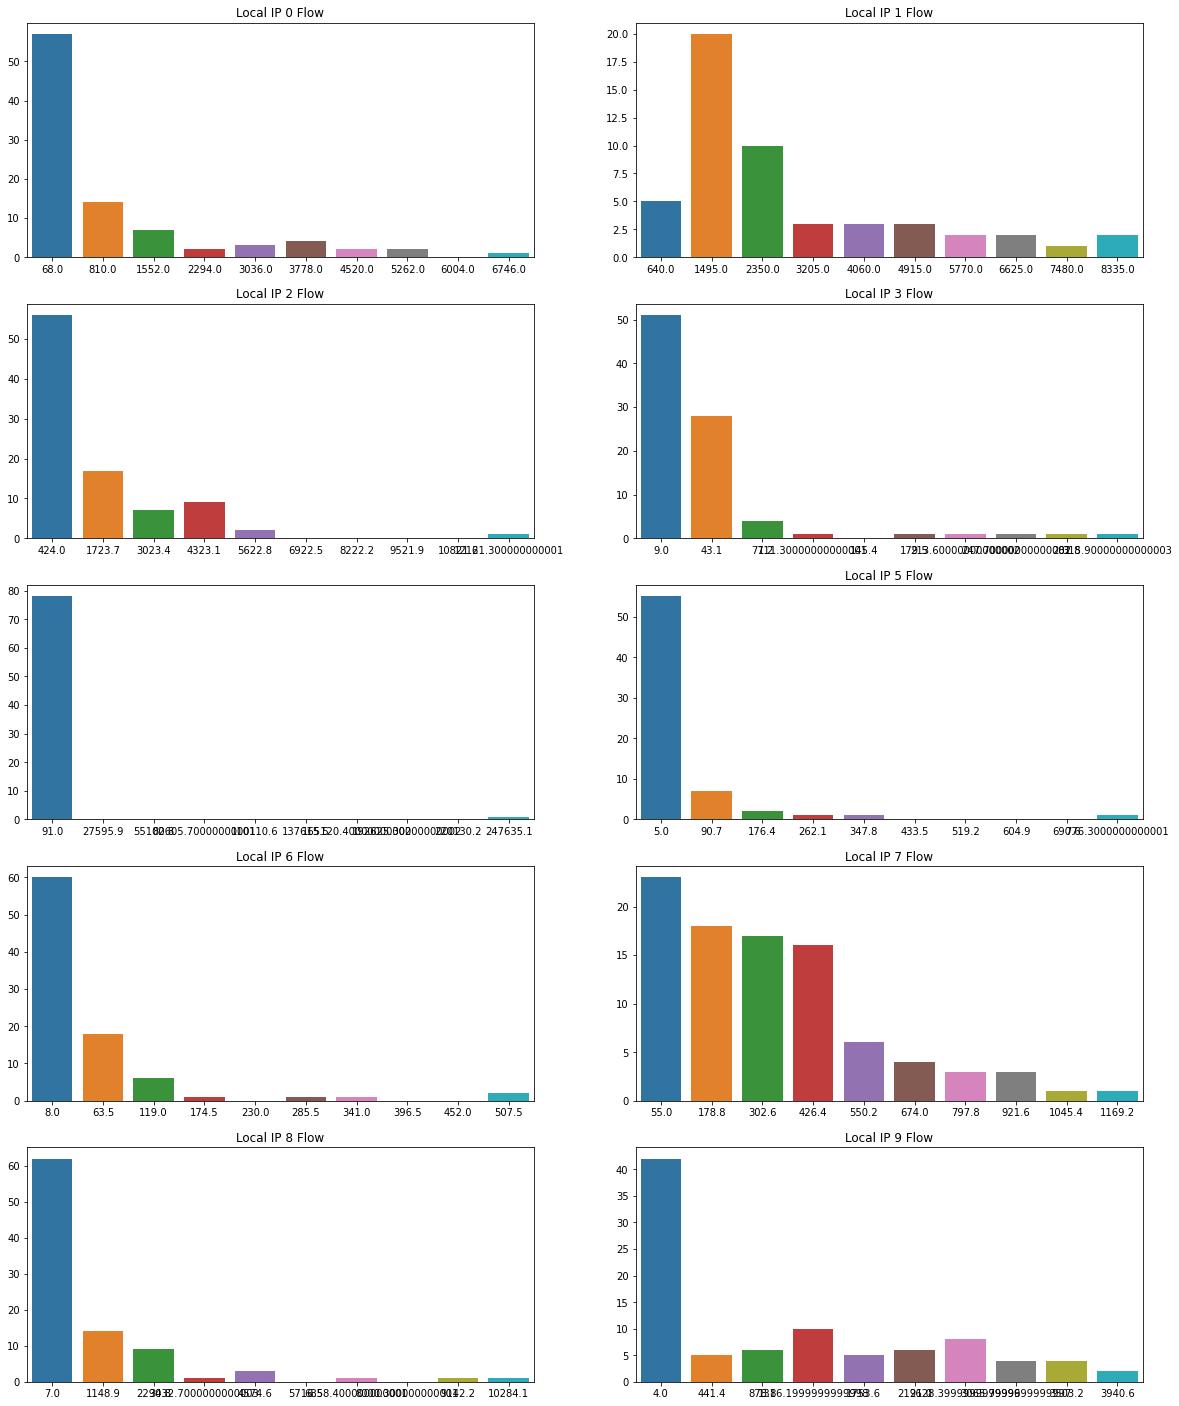

In [ ]:
f,axarray = plt.subplots(5,2,figsize=(20,25))
count, division = np.histogram(ip0['f'],bins=10)
g = sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[0,0])
axarray[0,0].set_title("Local IP 0 Flow")

count, division = np.histogram(ip1['f'],bins=10)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[0,1])
axarray[0,1].set_title("Local IP 1 Flow")

count, division = np.histogram(ip2['f'],bins=10)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[1,0])
axarray[1,0].set_title("Local IP 2 Flow")

count, division = np.histogram(ip3['f'],bins=10)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[1,1])
axarray[1,1].set_title("Local IP 3 Flow")

count, division = np.histogram(ip4['f'],bins=10)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[2,0])
axarray[2,1].set_title("Local IP 4 Flow")

count, division = np.histogram(ip5['f'],bins=10)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[2,1])
axarray[2,1].set_title("Local IP 5 Flow")

count, division = np.histogram(ip6['f'],bins=10)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[3,0])
axarray[3,0].set_title("Local IP 6 Flow")

count, division = np.histogram(ip7['f'],bins=10)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[3,1])
axarray[3,1].set_title("Local IP 7 Flow")

count, division = np.histogram(ip8['f'],bins=10)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[4,0])
axarray[4,0].set_title("Local IP 8 Flow")

count, division = np.histogram(ip9['f'],bins=10)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[4,1])
axarray[4,1].set_title("Local IP 9 Flow")

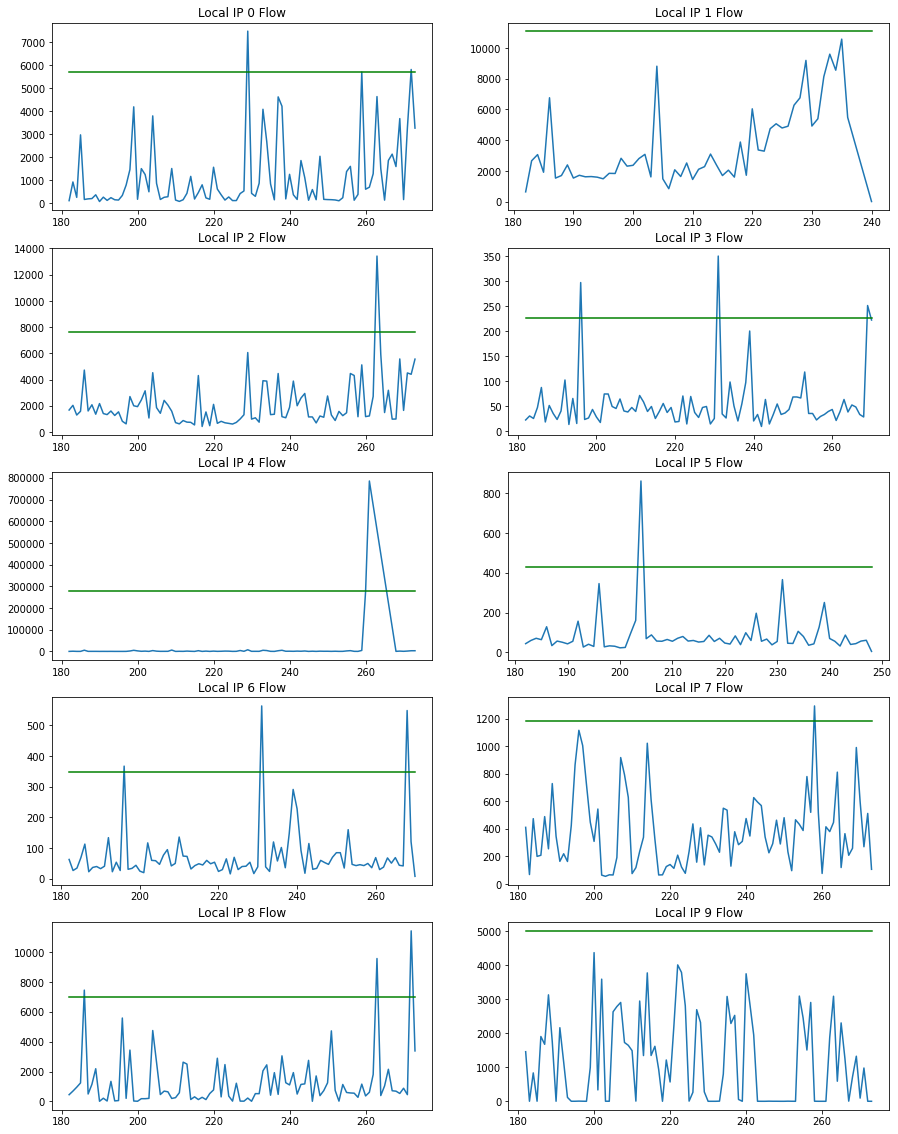

In [ ]:
f,axarray = plt.subplots(5,2,figsize=(15,20))
axarray[0,0].plot(ip0['yday'],ip0['f'])
axarray[0,0].plot(ip0['yday'], [ip0['f'].mean() + 3*ip0['f'].std()]*len(ip0['yday']),color='g')
axarray[0,0].set_title("Local IP 0 Flow")

axarray[0,1].plot(ip1['yday'], ip1['f'])
axarray[0,1].plot(ip1['yday'], [ip1['f'].mean() + 3*ip1['f'].std()]*len(ip1['yday']),color='g')
axarray[0,1].set_title("Local IP 1 Flow")

axarray[1,0].plot(ip2['yday'], ip2['f'])
axarray[1,0].set_title("Local IP 2 Flow")
axarray[1,0].plot(ip2['yday'], [ip2['f'].mean() + 3*ip2['f'].std(ddof=0)]*len(ip2['yday']),color='g')


axarray[1,1].plot(ip3['yday'], ip3['f'])
axarray[1,1].set_title("Local IP 3 Flow")
axarray[1,1].plot(ip3['yday'], [ip3['f'].mean() + 3*ip3['f'].std(ddof=0)]*len(ip3['yday']),color='g')


axarray[2,0].plot(ip4['yday'], ip4['f'])
axarray[2,0].set_title("Local IP 4 Flow")
axarray[2,0].plot(ip4['yday'], [ip4['f'].mean() + 3*ip4['f'].std(ddof=0)]*len(ip4['yday']),color='g')

axarray[2,1].plot(ip5['yday'], ip5['f'])
axarray[2,1].set_title("Local IP 5 Flow")
axarray[2,1].plot(ip5['yday'], [ip5['f'].mean() + 3*ip5['f'].std(ddof=0)]*len(ip5['yday']),color='g')

axarray[3,0].plot(ip6['yday'], ip6['f'])
axarray[3,0].set_title("Local IP 6 Flow")
axarray[3,0].plot(ip6['yday'], [ip6['f'].mean() + 3*ip6['f'].std(ddof=0)]*len(ip6['yday']),color='g')

axarray[3,1].plot(ip7['yday'], ip7['f'])
axarray[3,1].set_title("Local IP 7 Flow")
axarray[3,1].plot(ip7['yday'], [ip7['f'].mean() + 3*ip7['f'].std(ddof=0)]*len(ip7['yday']),color='g')

axarray[4,0].plot(ip8['yday'], ip8['f'])
axarray[4,0].set_title("Local IP 8 Flow")
axarray[4,0].plot(ip8['yday'], [ip8['f'].mean() + 3*ip8['f'].std(ddof=0)]*len(ip8['yday']),color='g')


axarray[4,1].plot(ip9['yday'], ip9['f'])
axarray[4,1].set_title("Local IP 9 Flow")
axarray[4,1].plot(ip9['yday'], [ip9['f'].mean() + 3*ip9['f'].std(ddof=0)]*len(ip9['yday']),color='g')

In [ ]:
ip0 = df[df['l_ipn']==0]
max0 = np.max(ip0['f'])
ip1 = df[df['l_ipn']==1][0:len(ip1['f'])-5]
max1 = np.max(ip1['f'])
ip2 = df[df['l_ipn']==2]
max2 = np.max(ip2['f'])
ip3 = df[df['l_ipn']==3]
max3 = np.max(ip3['f'])
ip4 = df[df['l_ipn']==4][0:len(ip4['f'])-7]

Text(0.5, 1.0, 'Local IP 4 Flow')

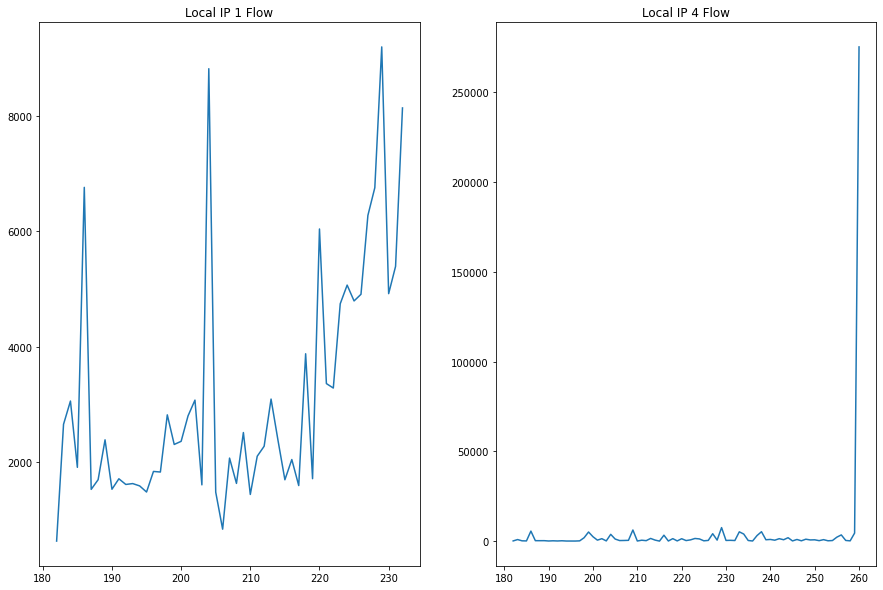

In [ ]:
f,axarray = plt.subplots(1,2,figsize=(15,10))
axarray[0].plot(ip1['yday'],ip1['f'])
axarray[0].set_title("Local IP 1 Flow")
axarray[1].plot(ip4['yday'], ip4['f'])
axarray[1].set_title("Local IP 4 Flow")

Text(0.5, 1.0, 'Local IP 4 Flow')

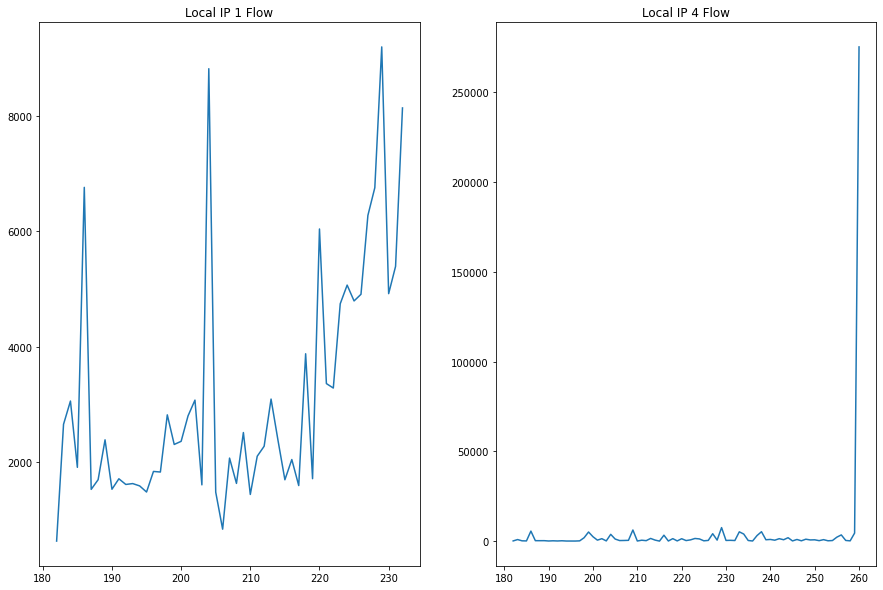

In [ ]:
f,axarray = plt.subplots(1,2,figsize=(15,10))
axarray[0].plot(ip1['yday'],ip1['f'])
axarray[0].set_title("Local IP 1 Flow")
axarray[1].plot(ip4['yday'], ip4['f'])
axarray[1].set_title("Local IP 4 Flow")

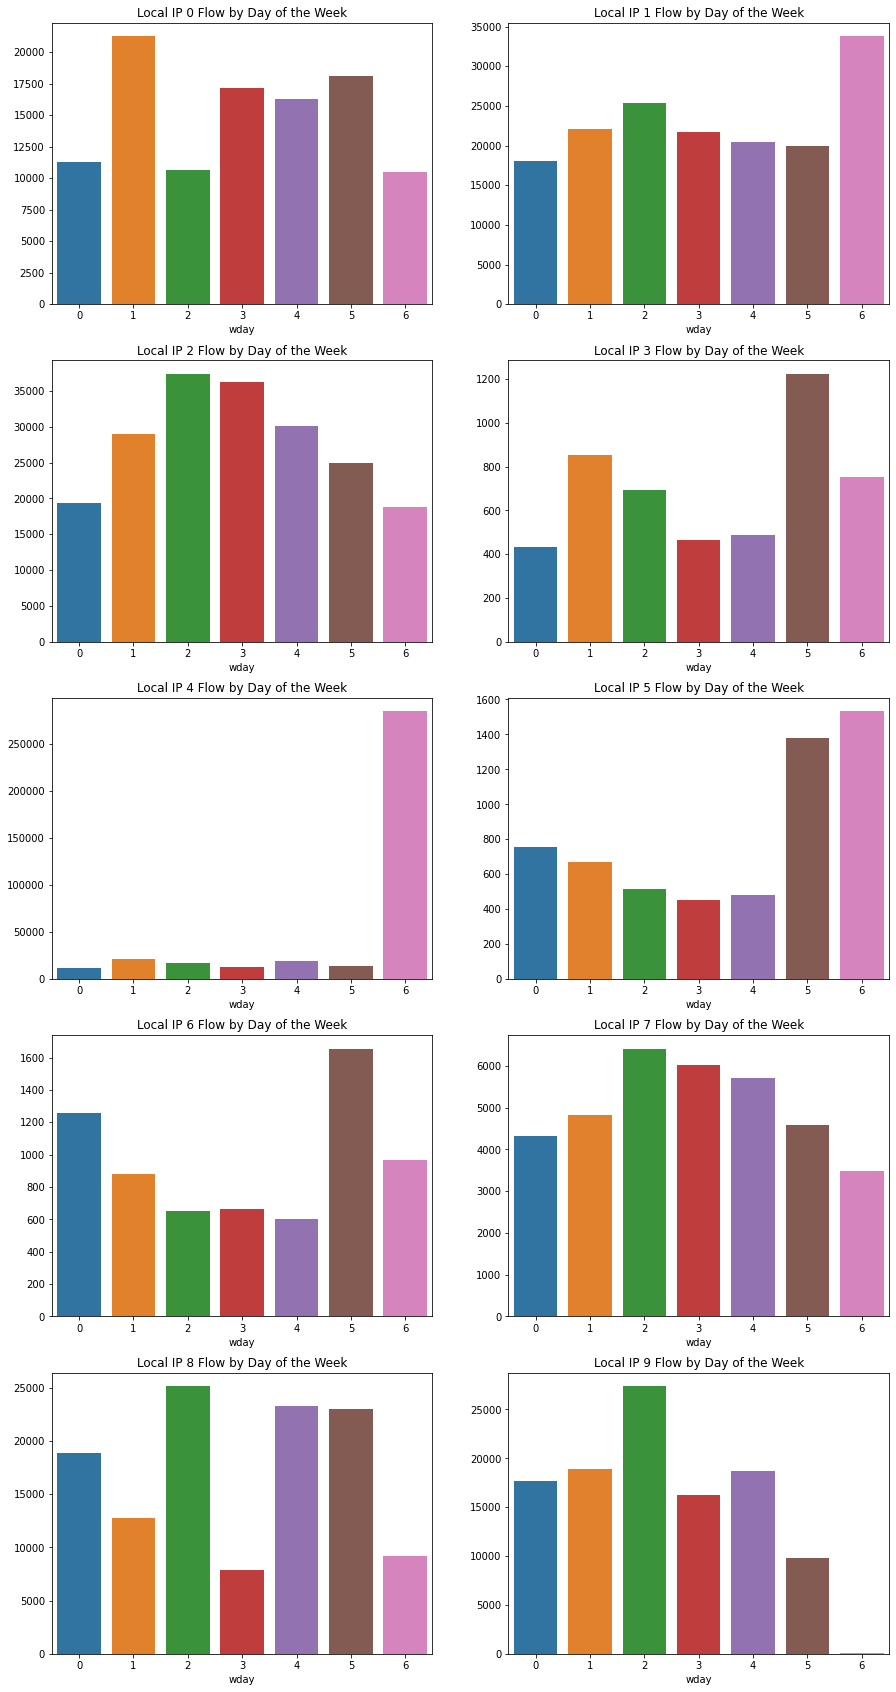

In [ ]:
f,axarray = plt.subplots(5,2,figsize=(15,30))
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip0.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[0,0])
axarray[0,0].set_title("Local IP 0 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip1.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[0,1])
axarray[0,1].set_title("Local IP 1 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip2.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[1,0])
axarray[1,0].set_title("Local IP 2 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip3.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[1,1])
axarray[1,1].set_title("Local IP 3 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip4.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[2,0])
axarray[2,0].set_title("Local IP 4 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip5.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[2,1])
axarray[2,1].set_title("Local IP 5 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip6.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[3,0])
axarray[3,0].set_title("Local IP 6 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip7.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[3,1])
axarray[3,1].set_title("Local IP 7 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip8.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[4,0])
axarray[4,0].set_title("Local IP 8 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip9.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[4,1])
axarray[4,1].set_title("Local IP 9 Flow by Day of the Week")

plt.show()

Predicting Flow - Reccurrent Neural Network
Recurrent Nural Network https://en.wikipedia.org/wiki/Recurrent_neural_network are a special type of NN where connections between nuerons crete cycles that make them depending, also, not just non the current input but, also, on the n previous inputs. This makes them particularly performing when it comes to predict time series.

In order to train it we create a feature dataset where each row contains the sequence of the prvious n (lookback variable) observations paired with the day of the week and the target value (y_train) is the flow to predict for the current day.

In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
fv =[float(v)/float(max0) for v in ip0['f'].values]
ip0.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max1) for v in ip1['f'].values]
ip1.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max2) for v in ip2['f'].values]
ip2.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max3) for v in ip3['f'].values]
ip3.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max4) for v in ip4['f'].values]
ip4.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max5) for v in ip5['f'].values]
ip5.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max6) for v in ip6['f'].values]
ip6.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max7) for v in ip7['f'].values]
ip7.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max8) for v in ip8['f'].values]
ip8.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max9) for v in ip9['f'].values]
ip9.loc[:,'f'] =np.array(fv).reshape(-1,1)  

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)].values
        dataX.append(a)
        dataY.append(dataset['f'].iloc[i + look_back])
    return np.array(dataX), np.array(dataY)

In [ ]:
from keras.layers import TimeDistributed 
from keras.constraints import nonneg
look_back = 14

def trainModel(data):
    data['f'] = data['f'].astype('float32')
    train = data[0:look_back*5].copy()
    trainX, trainY = create_dataset(train, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, 2))
    model = Sequential()
    model.add(GRU(64,input_shape=(trainX.shape[1], trainX.shape[2]),
               return_sequences=True))
    model.add(GRU(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=0)
    return model

In [ ]:
def predictFlow(_model,data):
    ypred=[0]*look_back
    #_max = np.max(data['f'])
    for k in range(len(data)-look_back):
        pattern = data[k:k+look_back].values
        x = np.reshape(pattern, (1, len(pattern), 2))
        ypred.append(_model.predict(x)[0][0])
    #ypred=[v*_max for v in ypred]
    return ypred

In [ ]:
m0 = trainModel(ip0[['f','wday']].copy())
m1 = trainModel(ip1[['f','wday']].copy())
m2 = trainModel(ip2[['f','wday']].copy())
m3 = trainModel(ip3[['f','wday']].copy())
m4 = trainModel(ip4[['f','wday']].copy())
m5 = trainModel(ip5[['f','wday']].copy())
m6 = trainModel(ip6[['f','wday']].copy())
m7 = trainModel(ip7[['f','wday']].copy())
m8 = trainModel(ip8[['f','wday']].copy())
m9 = trainModel(ip9[['f','wday']].copy())

1/1 [==============================] - 0s 20ms/step


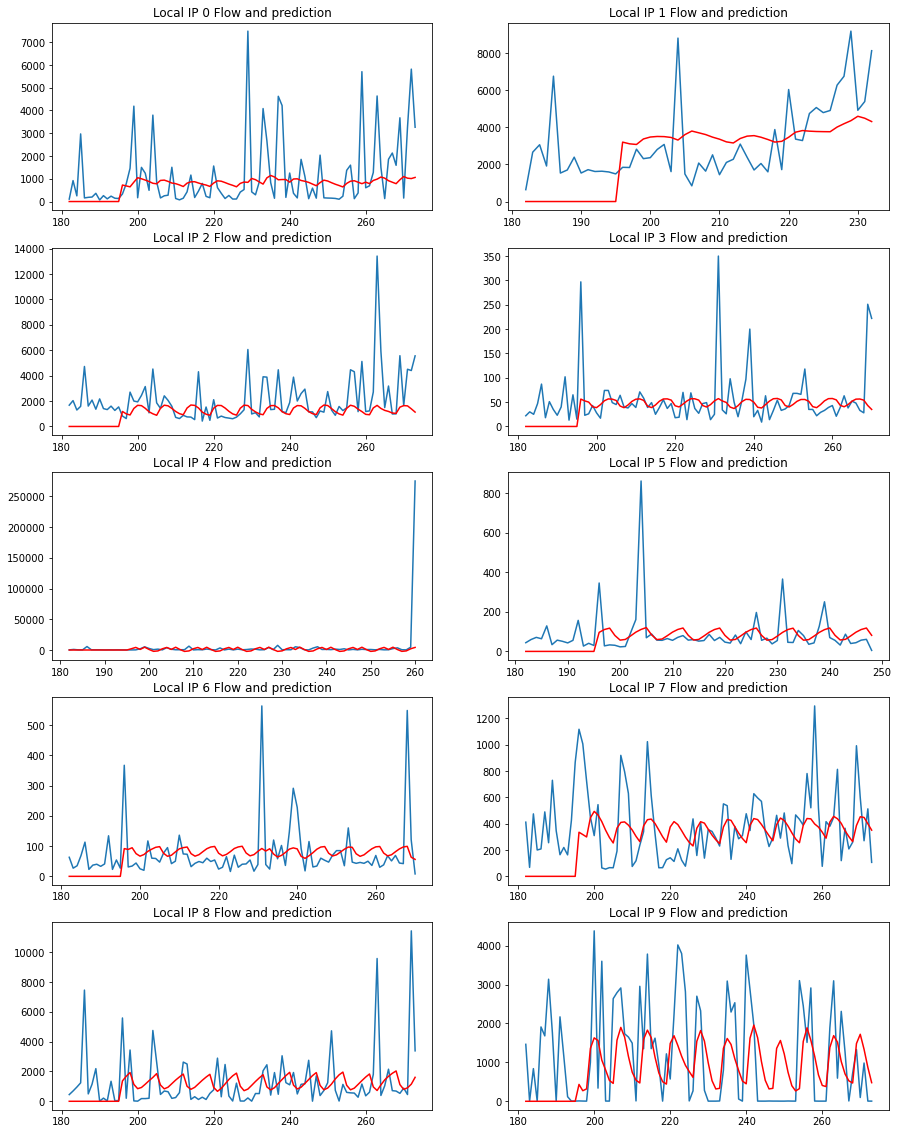

In [ ]:
f,axarray = plt.subplots(5,2,figsize=(15,20))

ypred0 = np.multiply(predictFlow(m0,ip0[['f','wday']].copy()),max0)
ip0f = np.multiply(ip0['f'],max0)
ypred1 = np.multiply(predictFlow(m1,ip1[['f','wday']].copy()),max1)
ip1f = np.multiply(ip1['f'],max1)
ypred2 = np.multiply(predictFlow(m2,ip2[['f','wday']].copy()),max2)
ip2f = np.multiply(ip2['f'],max2)

ypred3 = np.multiply(predictFlow(m3,ip3[['f','wday']].copy()),max3)
ip3f = np.multiply(ip3['f'],max3)
ypred4 = np.multiply(predictFlow(m4,ip4[['f','wday']].copy()),max4)
ip4f = np.multiply(ip4['f'],max4)
ypred5 = np.multiply(predictFlow(m5,ip5[['f','wday']].copy()),max5)
ip5f = np.multiply(ip5['f'],max5)

ypred6 = np.multiply(predictFlow(m6,ip6[['f','wday']].copy()),max6)
ip6f = np.multiply(ip6['f'],max6)
ypred7 = np.multiply(predictFlow(m7,ip7[['f','wday']].copy()),max7)
ip7f = np.multiply(ip7['f'],max7)
ypred8 = np.multiply(predictFlow(m8,ip8[['f','wday']].copy()),max8)
ip8f = np.multiply(ip8['f'],max8)
ypred9 = np.multiply(predictFlow(m9,ip9[['f','wday']].copy()),max9)
ip9f = np.multiply(ip9['f'],max9)

axarray[0,0].plot(ip0['yday'],ip0f)
axarray[0,0].plot(ip0['yday'],ypred0,color='r')
axarray[0,0].set_title("Local IP 0 Flow and prediction")

axarray[0,1].plot(ip1['yday'], ip1f)
axarray[0,1].plot(ip1['yday'], ypred1,color='r',alpha=1)
axarray[0,1].set_title("Local IP 1 Flow and prediction")

axarray[1,0].plot(ip2['yday'], ip2f)
axarray[1,0].plot(ip2['yday'], ypred2,color='r',alpha=1)
axarray[1,0].set_title("Local IP 2 Flow and prediction")

axarray[1,1].plot(ip3['yday'], ip3f)
axarray[1,1].plot(ip3['yday'], ypred3,color='r',alpha=1)
axarray[1,1].set_title("Local IP 3 Flow and prediction")

axarray[2,0].plot(ip4['yday'], ip4f)
axarray[2,0].plot(ip4['yday'], ypred4,color='r',alpha=1)
axarray[2,0].set_title("Local IP 4 Flow and prediction")

axarray[2,1].plot(ip5['yday'], ip5f)
axarray[2,1].plot(ip5['yday'], ypred5,color='r',alpha=1)
axarray[2,1].set_title("Local IP 5 Flow and prediction")

axarray[3,0].plot(ip6['yday'], ip6f)
axarray[3,0].plot(ip6['yday'], ypred6,color='r',alpha=1)
axarray[3,0].set_title("Local IP 6 Flow and prediction")

axarray[3,1].plot(ip7['yday'], ip7f)
axarray[3,1].plot(ip7['yday'], ypred7,color='r',alpha=1)
axarray[3,1].set_title("Local IP 7 Flow and prediction")

axarray[4,0].plot(ip8['yday'], ip8f)
axarray[4,0].plot(ip8['yday'], ypred8,color='r',alpha=1)
axarray[4,0].set_title("Local IP 8 Flow and prediction")

axarray[4,1].plot(ip9['yday'], ip9f)
axarray[4,1].plot(ip9['yday'], ypred9,color='r',alpha=1)
axarray[4,1].set_title("Local IP 9 Flow and prediction")
plt.show()

In [ ]:
corr0 = pd.Series(ip0f).corr(pd.Series(ypred0))
corr1 = pd.Series(ip1f).corr(pd.Series(ypred1))
corr2 = pd.Series(ip2f).corr(pd.Series(ypred2))
corr3 = pd.Series(ip3f).corr(pd.Series(ypred3))
corr4 = pd.Series(ip4f).corr(pd.Series(ypred4))
corr5 = pd.Series(ip5f).corr(pd.Series(ypred5))
corr6 = pd.Series(ip6f).corr(pd.Series(ypred6))
corr7 = pd.Series(ip7f).corr(pd.Series(ypred7))
corr8 = pd.Series(ip8f).corr(pd.Series(ypred8))
corr9 = pd.Series(ip9f).corr(pd.Series(ypred9))
corrdf = pd.DataFrame({'corr0':[corr0],
                       'corr1':[corr1],
                       'corr2':[corr2],
                       'corr3':[corr3],
                       'corr4':[corr4],
                       'corr5':[corr5],
                       'corr6':[corr6],
                       'corr7':[corr7],
                       'corr8':[corr8],
                       'corr9':[corr9]})
corrdf.head()

,corr0,corr1,corr2,corr3,corr4,corr5,corr6,corr7,corr8,corr9
0,-0.18,0.60,0.10,0.44,-0.00,0.17,-0.33,-0.20,0.11,-0.53


In [ ]:
ip0 = df[df['l_ipn']==0]
ip1 = df[df['l_ipn']==1][0:len(df[df['l_ipn']==1])-5]
ip2 = df[df['l_ipn']==2]
ip3 = df[df['l_ipn']==3]
ip4 = df[df['l_ipn']==4][0:len(df[df['l_ipn']==4])-7]
ip5 = df[df['l_ipn']==5]
ip6 = df[df['l_ipn']==6]
ip7 = df[df['l_ipn']==7]
ip8 = df[df['l_ipn']==8]
ip9 = df[df['l_ipn']==9]

In [ ]:
def ApEn(U, m, r):

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m + 1) - _phi(m))

In [ ]:
m=2
r = 3
e0 = ApEn(np.multiply(ip0['f'].values,1),m,r)
e1 = ApEn(np.multiply(ip1['f'].values,1),m,r)
e2 = ApEn(np.multiply(ip2['f'].values,1),m,r)
e3 = ApEn(np.multiply(ip3['f'].values,1),m,r)
e4 = ApEn(np.multiply(ip4['f'].values,1),m,r)
e5 = ApEn(np.multiply(ip5['f'].values,1),m,r)
e6 = ApEn(np.multiply(ip6['f'].values,1),m,r)
e7 = ApEn(np.multiply(ip7['f'].values,1),m,r)
e8 = ApEn(np.multiply(ip8['f'].values,1),m,r)
e9 = ApEn(np.multiply(ip9['f'].values,1),m,r)

In [ ]:
ent_values = pd.DataFrame({'e0':[e0], 'e1':[e1],'e2':[e2],'e3':[e3],'e4':[e4],'e5':[e5],
              'e6':[e6],'e7':[e7],'e8':[e8],'e9':[e9]})
ent_values.head()

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
0,0.01,0.02,0.01,0.36,0.01,0.17,0.29,0.00,0.01,0.26


 How IP flow entropies will evolves in time.

> Indented block



In [ ]:
def entropyTrend(data,d):
    etrend = [ApEn(np.multiply(data[n:n+d].values,1),2,3) for n in range(len(data)-d)]
    return etrend

Text(0.5, 1.0, 'Local IP 9 ApEn Variation')

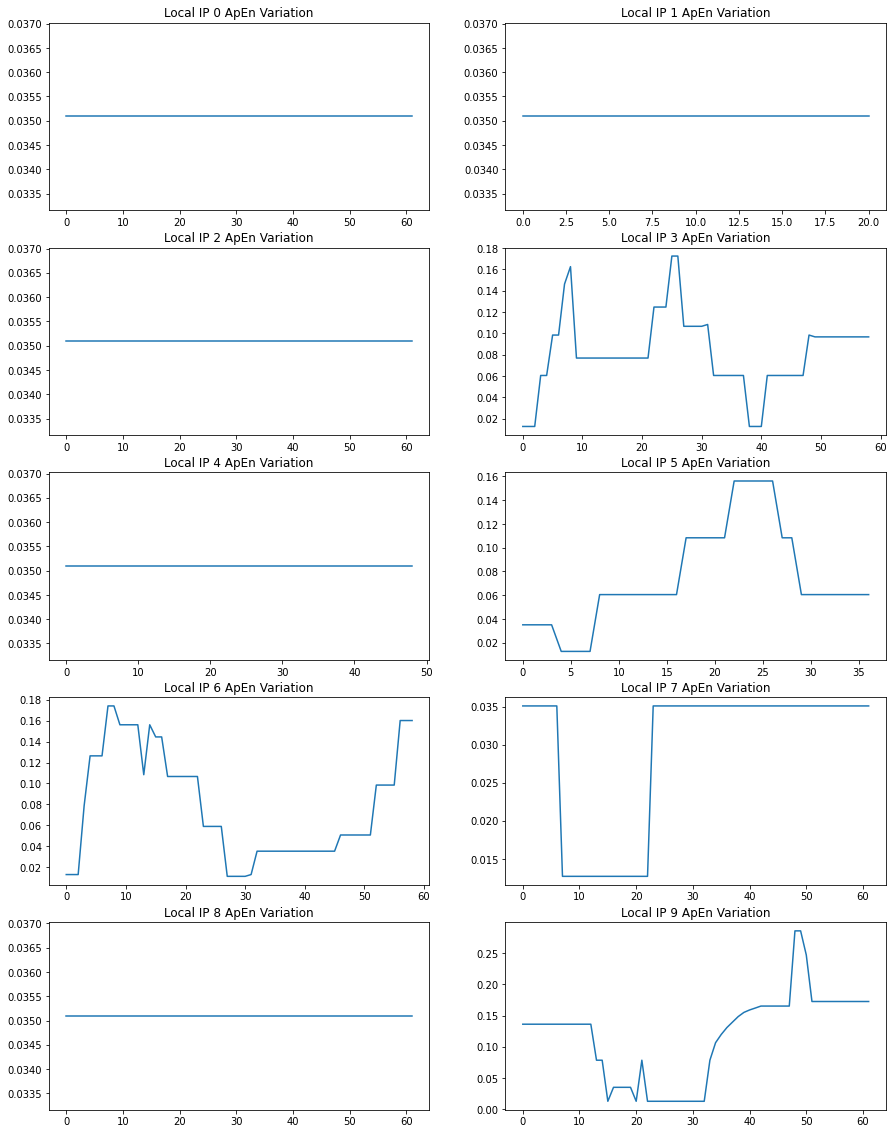

In [ ]:
f,axarray = plt.subplots(5,2,figsize=(15,20))
days = 30
et0 = entropyTrend(ip0['f'],days)
axarray[0,0].plot(range(len(et0)),et0)
axarray[0,0].set_title("Local IP 0 ApEn Variation")

et1 = entropyTrend(ip1['f'],days)
axarray[0,1].plot(range(len(et1)),et1)
axarray[0,1].set_title("Local IP 1 ApEn Variation")

et2 = entropyTrend(ip2['f'],days)
axarray[1,0].plot(range(len(et2)),et2)
axarray[1,0].set_title("Local IP 2 ApEn Variation")

et3 = entropyTrend(ip3['f'],days)
axarray[1,1].plot(range(len(et3)),et3)
axarray[1,1].set_title("Local IP 3 ApEn Variation")

et4 = entropyTrend(ip4['f'],days)
axarray[2,0].plot(range(len(et4)),et4)
axarray[2,0].set_title("Local IP 4 ApEn Variation")

et5 = entropyTrend(ip5['f'],days)
axarray[2,1].plot(range(len(et5)),et5)
axarray[2,1].set_title("Local IP 5 ApEn Variation")

et6 = entropyTrend(ip6['f'],days)
axarray[3,0].plot(range(len(et6)),et6)
axarray[3,0].set_title("Local IP 6 ApEn Variation")

et7 = entropyTrend(ip7['f'],days)
axarray[3,1].plot(range(len(et7)),et7)
axarray[3,1].set_title("Local IP 7 ApEn Variation")

et8 = entropyTrend(ip8['f'],days)
axarray[4,0].plot(range(len(et8)),et8)
axarray[4,0].set_title("Local IP 8 ApEn Variation")

et9 = entropyTrend(ip9['f'],days)
axarray[4,1].plot(range(len(et9)),et9)
axarray[4,1].set_title("Local IP 9 ApEn Variation")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import matplotlib.patches as patches
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import matplotlib.patches as patches
%matplotlib inline

In [ ]:
grouped = df[['date','l_ipn','f']].groupby(['date','l_ipn'])
res = grouped[['f']].agg(['sum','count'])['f'][['sum','count']];

Total traffic by host

In [ ]:
res=res.rename(columns={"sum": "connections_count", "count": "isp_count"})
print (res.groupby(level=1).sum().reset_index())
res = res.reset_index()     ## reset grouping
res.head(15)                ## show sample

   l_ipn  connections_count  isp_count
0      0             105177         92
1      1             195691         56
2      2             195713         92
3      3               4904         89
4      4            1175417         86
5      5               5780         67
6      6               6674         89
7      7              35362         92
8      8             120203         92
9      9             108777         92


,date,l_ipn,connections_count,isp_count
0,2006-07-01,0,106,1
1,2006-07-01,1,640,1
2,2006-07-01,2,1677,1
3,2006-07-01,3,22,1
4,2006-07-01,4,184,1
5,2006-07-01,5,44,1
6,2006-07-01,6,63,1
7,2006-07-01,7,411,1
8,2006-07-01,8,448,1
9,2006-07-01,9,1463,1


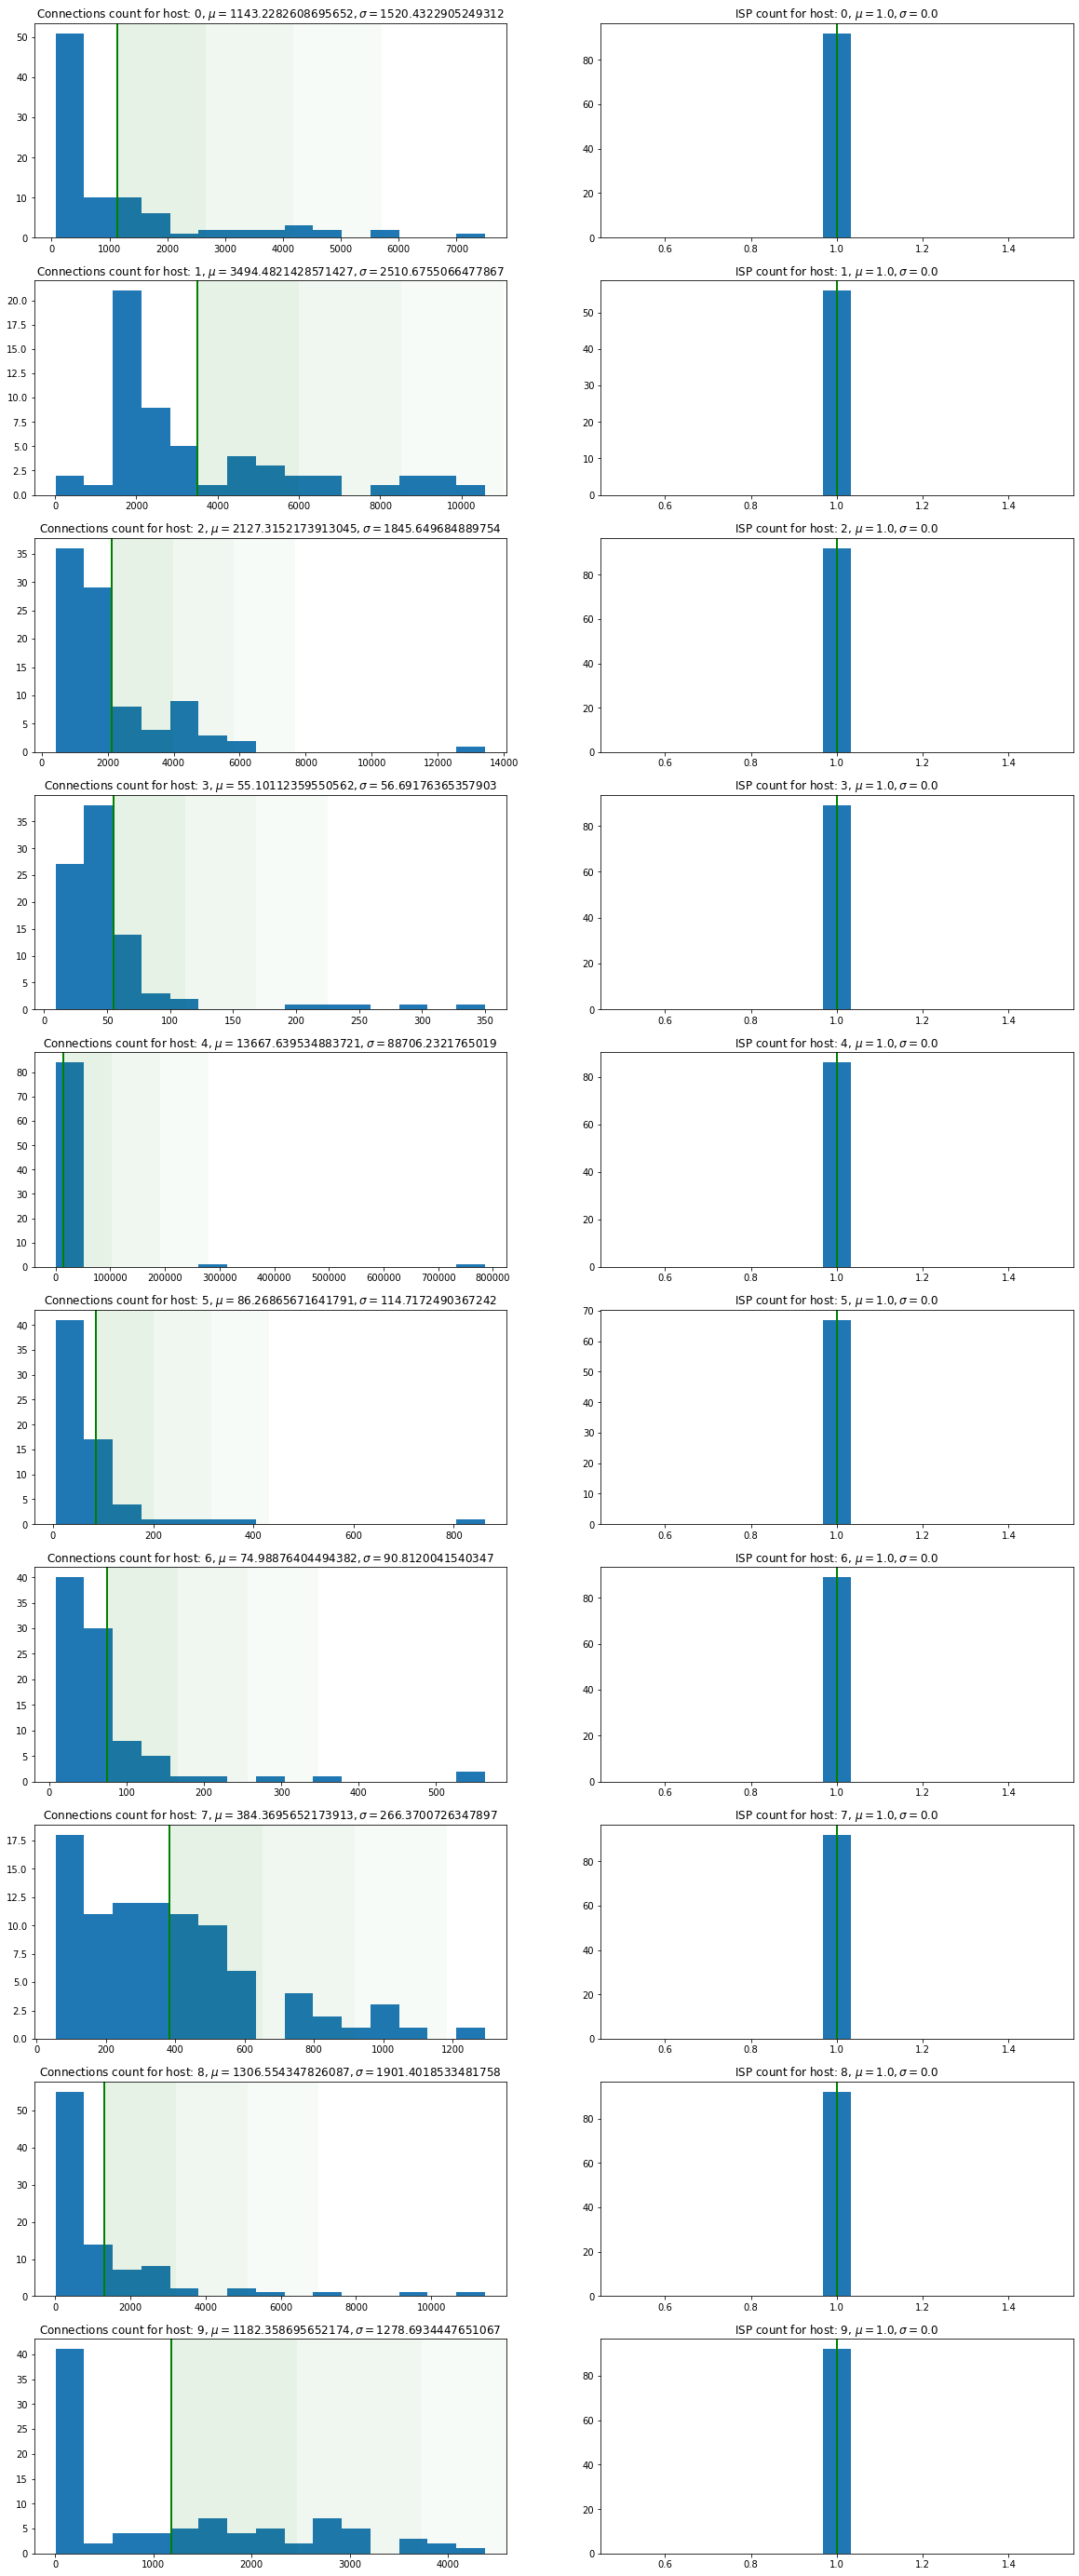

In [ ]:
df0=res
df0=df0.rename(columns={"connections_count":"f", "isp_count":"cnt"})
plt.rcParams['figure.figsize']=20,50
f,axes = plt.subplots(10, 2, sharey=False)

for i in range(10):
    b=15
    mu=df0[df0.l_ipn==i]["f"].values.mean()
    s=df0[df0.l_ipn==i]["f"].values.std()
    axes[i][0].set_title('Connections count for host: '+str(i)+', $ \mu=' + str(mu) + ', \sigma=' + str(s) +'$')
    axes[i][0].hist(df0[df0.l_ipn==i]["f"].values,bins=b,label='ISP count for host:')
    axes[i][0].axvline(mu,color='g',linewidth=2)
    #axes[i][0].axvline(mu+s+s+s,color='r',linewidth=1)
    rect = patches.Rectangle((mu,0), s, axes[i][0].get_ylim()[1], linewidth=0,facecolor='g',alpha=0.1)
    axes[i][0].add_patch(rect)
    rect = patches.Rectangle((mu+s,0), s, axes[i][0].get_ylim()[1], linewidth=0,facecolor='g',alpha=0.06)
    axes[i][0].add_patch(rect)
    rect = patches.Rectangle((mu+s+s,0), s, axes[i][0].get_ylim()[1], linewidth=0,facecolor='g',alpha=0.03)
    axes[i][0].add_patch(rect)
    
    mu=df0[df0.l_ipn==i]["cnt"].values.mean()
    s=df0[df0.l_ipn==i]["cnt"].values.std()   
    axes[i][1].set_title('ISP count for host: '+str(i)+', $ \mu=' + str(mu) + ', \sigma=' + str(s) +'$')
    axes[i][1].hist(df0[df0.l_ipn==i]["cnt"].values,bins=b)
    axes[i][1].axvline(mu,color='g',linewidth=2)
    #axes[i][1].axvline(mu+s+s+s,color='r',linewidth=1)    
    rect = patches.Rectangle((mu,0), s, axes[i][1].get_ylim()[1], linewidth=0,facecolor='g',alpha=0.1)
    axes[i][1].add_patch(rect)
    rect = patches.Rectangle((mu+s,0), s, axes[i][1].get_ylim()[1], linewidth=0,facecolor='g',alpha=0.06)
    axes[i][1].add_patch(rect)
    rect = patches.Rectangle((mu+s+s,0), s, axes[i][1].get_ylim()[1], linewidth=0,facecolor='g',alpha=0.03)
    axes[i][1].add_patch(rect)

Here I detect Botnet Using Recurring Neural Network, Prophet Library and Luminol.